In [9]:
import pickle
import torch
from models.timegan import TimeGAN
from models.utils import rescale
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
path="/home/rzhou/Projects/timegan-pytorch/output/inD_multi_Epoch5000_withoutZfilter_min_G_Loss_period1000epoch"
with open(f"{path}/args.pickle", "rb") as fb:
    args = torch.load(fb)
with open(f"{path}/fake_time.pickle", "rb") as fb:
    fake_time = pickle.load(fb)
print(args)

fake_time = torch.tensor(fake_time, dtype=torch.float32)
print(fake_time)
print(len(fake_time)) 

Namespace(device='cuda', exp='inD_multi_Epoch5000_withoutZfilter_min_G_Loss_period1000epoch', is_train=True, seed=42, feat_pred_no=1, max_seq_len=100, train_rate=0.5, scaling_method='minmax', emb_epochs=5000, sup_epochs=5000, gan_epochs=5000, batch_size=128, hidden_dim=20, num_layers=3, dis_thresh=0.15, optimizer='adam', learning_rate=0.001, model_path='/home/rzhou/Projects/timegan-pytorch/output/inD_multi_Epoch5000_withoutZfilter_min_G_Loss_period1000epoch', padding_value=-10.0, feature_dim=10, Z_dim=10)
tensor([100., 100., 100.,  ..., 100., 100., 100.])
1773


In [25]:
from data.data_preprocess import data_preprocess
data_path="/DATA1/rzhou/ika/multi_testcases/inD_multi_full.csv"
X, T, params_rescale, args.max_seq_len, args.padding_value = data_preprocess(
    file_name=data_path, max_seq_len=args.max_seq_len,scaling_method=args.scaling_method
)

Loading data...



100%|██████████| 3546/3546 [00:03<00:00, 952.86it/s]


In [30]:

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeGAN(args)
model_path = "/home/rzhou/Projects/timegan-pytorch/output/inD_multi_Epoch5000_withoutZfilter_min_G_Loss_period1000epoch/min_G_loss_model_epoch_3000.pt"
model.load_state_dict(torch.load(model_path))
model.to(args.device)
model.eval()
with torch.no_grad():
    # Generate fake data
    Z = torch.rand((len(fake_time), args.max_seq_len, args.Z_dim))
    generated_data = model(X=None, T=fake_time, Z=Z, obj="inference").numpy()

In [24]:
from data.data_preprocess import data_preprocess
data_path="/DATA1/rzhou/ika/multi_testcases/inD_multi_full.csv"
X, T, params_rescale, args.max_seq_len, args.padding_value = data_preprocess(
    file_name=data_path, max_seq_len=args.max_seq_len,scaling_method=args.scaling_method
)

Loading data...



100%|██████████| 3546/3546 [00:03<00:00, 966.49it/s]


In [38]:
rescaled_generated_data=rescale(generated_data,args.scaling_method,params_rescale)
print(rescaled_generated_data[0][:,0])

[53.693905 56.14267  46.45518  41.588062 46.864594 54.070614 57.507465
 57.608166 58.066864 58.530518 59.96658  61.228233 61.67694  62.623016
 63.771244 64.07951  64.94944  64.17793  64.80331  64.77189  65.255325
 65.27692  65.58153  65.336426 65.7038   65.61134  66.354996 66.3203
 66.73165  66.28355  66.8974   66.9259   67.1614   67.175674 67.37832
 67.54931  67.539345 67.710045 67.83585  68.14328  68.6448   68.81104
 69.18429  69.11781  69.54867  69.978294 70.07203  70.483826 69.55534
 70.30963  69.912025 71.469666 70.89701  71.657005 70.97581  71.69322
 71.39814  71.6702   71.712944 72.31075  72.41673  72.79986  72.65403
 73.10453  73.042465 72.99622  73.28899  73.16202  73.2286   73.34489
 73.38226  74.13366  74.02003  74.42183  74.37683  74.68288  74.57532
 74.888306 75.39368  75.62078  75.98763  75.98087  76.2559   76.45484
 76.24287  76.54543  76.51118  76.38917  76.56676  76.49751  77.11137
 76.88216  77.21395  76.15181  76.90452  76.273415 77.51685  76.98204
 77.562294 77.4829

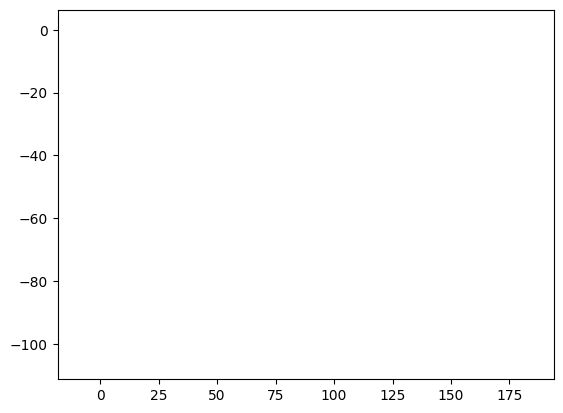

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 假定rescaled_generated_data为(1773, 100, 10)的NumPy数组
# 请确保已经正确加载了rescaled_generated_data

frames_per_second = 5  # 定义每秒展示的帧数
total_seconds_per_case = 20  # 定义每个案例表示的总秒数
frames_per_case = frames_per_second * total_seconds_per_case  # 计算每个案例的总帧数

# 创建图形和轴
fig, ax = plt.subplots()

# 根据数据设置轴界限
# 注意：这里假设x和y坐标分别位于最后一维的偶数和奇数索引位置
x_min, x_max = np.min(rescaled_generated_data[..., ::2]), np.max(rescaled_generated_data[..., ::2])
y_min, y_max = np.min(rescaled_generated_data[..., 1::2]), np.max(rescaled_generated_data[..., 1::2])
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# 初始化绘制点的占位符，此处对应5个点
points = [ax.plot([], [], 'o', label=f'Point {i+1}')[0] for i in range(5)]

# 初始化函数，设置动画开始时的背景
def init():
    for point in points:
        point.set_data([], [])
    return points

# 更新函数，用于动画的每一帧
def update(frame):
    # 根据总帧数来计算当前应该展示的数据索引
    current_index = frame % 100  # 每100帧数据对应一个完整周期
    # 假设rescaled_generated_data.shape[0]给出了数据集的总行数
    total_rows = rescaled_generated_data.shape[0]
    random_indices = np.random.choice(total_rows, 5, replace=False)

    # 根据帧数选择对应的数据
    for i, point in enumerate(points):
        # 选择对应案例的数据
        case_data = rescaled_generated_data[random_indices[i]]  # 选择最后五行作为案例
        x = case_data[current_index, i*2]  # x坐标
        y = case_data[current_index, i*2+1]  # y坐标
        point.set_data(x, y)
    return points

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=total_seconds_per_case * frames_per_second,
                              init_func=init, blit=True, repeat=True)

plt.show()

# 注意：由于当前环境限制，实际保存动画需在你的本地环境执行
ani.save('trajectory_animation.mp4', fps=frames_per_second, extra_args=['-vcodec', 'libx264'])
